# Analyzing IBM API output 

Process expects:

    - case transcript (.txt) and audio (.wav) in outer data folder 
    - caseinfo/ folder in same directory as notebook (containg curl output)
    - take snippet of wav (max ~45 min) for IBM byte limit
    
Procedure:

    - curl call to IBM S2T server
    - true and IBM transcription to RTTM
    - pyannote visualization & evaluation (Focus on Segmentation)

In [1]:
import json, csv
from pyannote.database.util import load_rttm
from pyannote.audio.features import RawAudio
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.segmentation import *
import seaborn as sns
sns.set(style = "darkgrid")

case_name = '19-518' # test case for processing
OWN_FILE = {'audio': '../data/'+case_name+'_45.wav'} #45 min split
transcript_path = '../data/'+case_name+'.txt'

#sample outputs
api_out_file_name_ibm = 'caseinfo/case19518_IBMtranscript.json'
case19inRTTM = 'caseinfo/19518_Truelabels.rttm'
case19IBMRTTM = 'caseinfo/19518_IBMlabels.rttm'

time_trunc = 45*60
sr=16000

### IBM Python SDK (doesn't seem to work)

In [ ]:
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

api = '...' #add api for python sdk
url = 'https://api.us-south.speech-to-text.watson.cloud.ibm.com/instances/7efdb89d-7345-44e8-b67a-a39e31c2b0e2/v1/recognize'


authenticator = IAMAuthenticator(api)
speech_to_text = SpeechToTextV1(
    authenticator=authenticator
)

speech_to_text.set_service_url(url)

In [ ]:
speech_models = speech_to_text.list_models().get_result()
print(json.dumps(speech_models, indent=2))

### IBM CURL API call notes

##### issue making calls thru python, curl works

case19-518 -> first 45min (IBM API size limit)

uses your own ```api_key```

```
curl -X POST -u "apikey:api_key" \
--header "Content-Type: audio/wav" \
--data-binary @data/19-518_45.wav \
"https://api.us-south.speech-to-text.watson.cloud.ibm.com/instances/7efdb89d-7345-44e8-b67a-a39e31c2b0e2/v1/recognize?speaker_labels=true&audio_metrics=true" > caseinfo/case19518_IBMtranscript.json
```

#### Args to tune:

- speaker_labels=true
- audio_metrics=true
- ----------
- model = en-US_NarrowbandModel (same results as broad, use for <16k)
- acoustic_customization_id
- base_model_version
- keywords
- end_of_phrase_silence_time
- split_transcript_at_phrase_endl

## True Case Diarization
    - Conversion to RTTM

In [3]:
TL = []
trl = []
cap = 0

f = open(transcript_path,'r')
k = f.readlines()
f.close()

for u in k:
    if len(u)>=3:
        t0, t1, spkr = u.split(' ')[0:3]
        trans = u.split(spkr)[-1]
        if float(t0)>time_trunc:
            #print(float(t0), float(t1), spkr)
            cap+=1
        TL.append((float(t0),float(t1),spkr))
        trl.append(trans)
        
# handle 45 min limit        
timelst = TL[:-cap] 
trans_lst = trl[:-cap]

In [4]:
case_rttm = []
for i, event in enumerate(timelst):
    case_rttm.append(' '.join(['SPEAKER '+case_name+' 1', str(event[0]), str(round(event[1]-event[0], 2)), '<NA> <NA>', event[2],'<NA> <NA>']))

with open(case19inRTTM, 'w') as filehandle:
    for listitem in case_rttm:
        filehandle.write('%s\n' % listitem)
        
waveform = RawAudio(sample_rate=sr)(OWN_FILE).data
groundtruths = load_rttm(case19inRTTM)[case_name]
len(case_rttm)

150

In [5]:
#import rttm in 
with open(case19inRTTM, newline='\n') as f:
    reader = csv.reader(f)
    case19_diary = list(reader)

## IBM Speech2Text API Diarization 

In [6]:
with open(api_out_file_name_ibm) as f:
    ibm = json.load(f)
    
print(ibm.keys(), len(ibm['results']), len(ibm['speaker_labels']))

dict_keys(['result_index', 'results', 'speaker_labels', 'audio_metrics']) 186 6767


In [19]:
ibm['audio_metrics']

{'accumulated': {'clipping_rate': [{'count': 27000, 'end': 1e-05, 'begin': 0},
   {'count': 0, 'begin': 1e-05, 'end': 0.0001},
   {'count': 0, 'begin': 0.0001, 'end': 0.001},
   {'count': 0, 'begin': 0.001, 'end': 0.01},
   {'count': 0, 'begin': 0.01, 'end': 0.1},
   {'count': 0, 'begin': 0.1, 'end': 1}],
  'end_time': 2700.0,
  'final': True,
  'high_frequency_loss': 0.282,
  'non_speech_level': [{'count': 0, 'end': 0.1, 'begin': 0},
   {'count': 4, 'begin': 0.1, 'end': 0.2},
   {'count': 2949, 'begin': 0.2, 'end': 0.3},
   {'count': 962, 'begin': 0.3, 'end': 0.4},
   {'count': 853, 'begin': 0.4, 'end': 0.5},
   {'count': 308, 'begin': 0.5, 'end': 0.6},
   {'count': 89, 'begin': 0.6, 'end': 0.7},
   {'count': 23, 'begin': 0.7, 'end': 0.8},
   {'count': 14, 'begin': 0.8, 'end': 0.9},
   {'count': 0, 'begin': 0.9, 'end': 1}],
  'speech_level': [{'count': 0, 'end': 0.1, 'begin': 0},
   {'count': 1, 'begin': 0.1, 'end': 0.2},
   {'count': 109, 'begin': 0.2, 'end': 0.3},
   {'count': 192, 

### to RTTM

In [7]:
ibm_rttm = []
ibm_trans = []

for r in ibm['results']:
    #print(r.keys())
    for i in r['alternatives']:
        #print(i.keys())
        trans = i['transcript']
        start, end = i['timestamps'][0][1], i['timestamps'][-1][-1]
        for item in ibm['speaker_labels']:
            if end==item['to']:
                label = item['speaker']
        out = 'SPEAKER '+case_name+' 1 '+str(start)+' '+str(round(end-start, 3))+' <NA> <NA> '+str(label)+' <NA> <NA>'
        #print(out)
        ibm_rttm.append(out)
        ibm_trans.append((trans, label))
        
with open(case19IBMRTTM, 'w') as filehandle:
    for listitem in ibm_rttm:
        filehandle.write('%s\n' % listitem)

ibm_truths = load_rttm(case19IBMRTTM)[case_name]
print(len(ibm_rttm))

186


In [8]:
with open(case19IBMRTTM, newline='\n') as f:
    reader = csv.reader(f)
    ibm_diary = list(reader)

# Diarization Visualization & Evaluation (w/ pyannote.metrics)

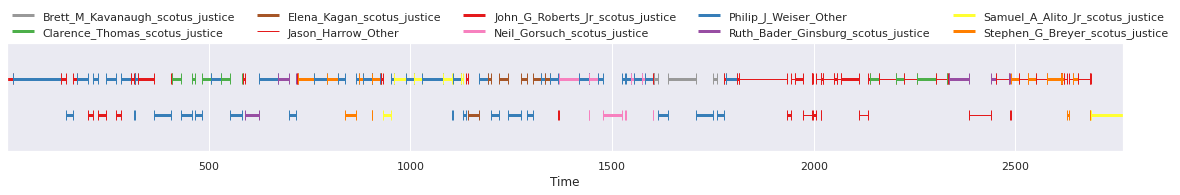

In [9]:
groundtruths

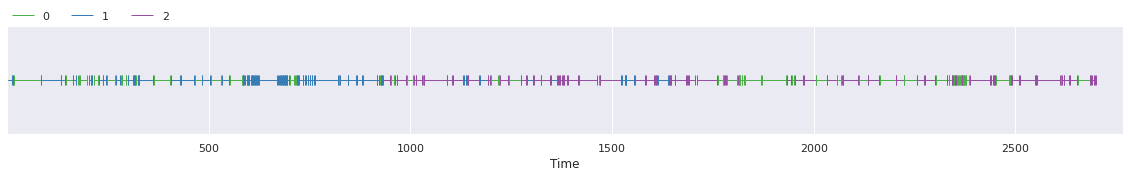

In [10]:
ibm_truths

In [11]:
metric = DiarizationErrorRate(collar=.3, skip_overlap=True)
metric(groundtruths, ibm_truths, detailed=True)

/home/jtumm13d/anaconda3/envs/audio_pyannnote/lib/python3.7/site-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'confusion': 1646.2699998499938,
 'total': 2721.9850002499848,
 'false alarm': 0.0,
 'missed detection': 330.7150003499919,
 'correct': 745.000000049999,
 'diarization error rate': 0.7263026798525418}

In [12]:
report = metric.report(display=True)

       diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                            %                       %                       %                                 %                   %
item                                                                                                                               
19-518                  72.63 2721.99  745.00   27.37        0.00        0.00           330.72            12.15   1646.27     60.48
TOTAL                   72.63 2721.99  745.00   27.37        0.00        0.00           330.72            12.15   1646.27     60.48


In [13]:
rec = SegmentationRecall(tolerance=.5)
rec(groundtruths, ibm_truths, detailed=True)

{'number of boundaries': 149,
 'number of matches': 12.0,
 'segmentation recall': 0.08053691275167785}

In [14]:
prec = SegmentationPrecision(tolerance=.5)
prec(groundtruths, ibm_truths, detailed=True)

{'number of boundaries': 185,
 'number of matches': 12.0,
 'segmentation precision': 0.06486486486486487}

In [15]:
cov = SegmentationCoverage()
cov(groundtruths, ibm_truths, detailed=True)

{'total duration': 2699.7599995499972,
 'intersection duration': 2078.034999249996,
 'segmentation coverage': 0.7697110111996504}

In [16]:
pur = SegmentationPurity()
pur(groundtruths, ibm_truths, detailed=True)

{'total duration': 2699.759999549997,
 'intersection duration': 2466.3950003500013,
 'segmentation purity': 0.9135608353191049}

In [17]:
fsc = SegmentationPurityCoverageFMeasure()
fsc(groundtruths, ibm_truths, detailed=True)

{'pty intersection duration': 2466.3950003500013,
 'cvg intersection duration': 2078.034999249996,
 'cvg total duration': 2699.7599995499972,
 'pty total duration': 2699.7599995499972,
 'segmentation F[purity|coverage]': 0.8354893308530489}